In [64]:
import pandas as pd
import numpy as np
import matplotlib # Import package matplotlib for data visualization
from matplotlib import pyplot as plt # Import pyplot from matplotlib to have a high-level MATLAB-like plotting
import operator
import statsmodels.api as sm
from tqdm import tqdm

SP500 = pd.read_csv('SP500_2022.csv')
Benchmark = pd.read_csv('Benchmark2022.csv')
Data = pd.read_csv('Data2022.csv')

Data['date'] = pd.to_datetime(Data['date'].astype(str), format='%Y%m%d') # Format 'date' from string to datetime in YYYYmmdd
Data['date'] = Data['date'].apply(lambda x:x.strftime('%Y%m'))
Data['date'] = Data['date'].astype(int) # Convert 'date' to int YYYYmm which removes dd from the original str 'date' 

Date_Unique = sorted(Data['date'].unique()) # Create date index
Gvkey_Unique = sorted(Data['gvkey'].unique()) # Create stock identifier index
idx_t_start = Date_Unique.index(197001) # Starting date of the backtesting 
idx_t_end = Date_Unique.index(202212) # Ending date of the backtesting
Date_Unique = Date_Unique[idx_t_start: idx_t_end+1] # Include date between the start date and end date

# Create a list of dataframes that contains all data in the corresponding unique date 
list_firm_date = []
for idx_date in tqdm(Date_Unique):
    list_firm_date.append(Data[Data['date'].isin([idx_date])].sort_values('gvkey',inplace = False).reset_index(drop=True))

100%|██████████| 636/636 [00:02<00:00, 307.86it/s]


In [45]:
# Make sure we use only point-in-time data, no look ahead bias
Factor_SP500 = [] #whether the firm is a member of SP500
Factor_HL1M = [] # Price Momentum
Factor_MV = []  #Market Cap
Factor_BM = [] #Book to Price
Factor_AdjPrice = []   #Adjusted Closing Price Prccm
Factor_RET = []   #Monthly Return, this is also the dependent varaiable

for idx_t in tqdm(Date_Unique):
    df_firm = list_firm_date[Date_Unique.index(idx_t)].copy(deep=True)
    
    #Construct the signal for each factor
    
    #SP500 Indicator: member == 1, nonmember ==0;
    Factor_SP500.append(df_firm[['sp500','gvkey']])
    
    df_firm['MV'] = df_firm['cshoq'] * 1000000 * df_firm['prccm']
    df_firm = df_firm[df_firm['MV'] > 0]  # Keep only positive values
    df_firm['MV'] = np.log(df_firm['MV'])
    Factor_MV.append(df_firm[['MV','gvkey']]) #Log Market Cap
    df_firm = df_firm.drop(['MV'], axis =1)
    
    df_firm['BM'] = df_firm['ceqq']*1000000/(df_firm['cshoq']*1000000*df_firm['prccm'])
    Factor_BM.append(df_firm[['BM','gvkey']]) #Book to price
    df_firm = df_firm.drop(['BM'],axis=1)
    
    df_firm['HL1M'] = (df_firm['prchm'] - df_firm['prccm'])/(df_firm['prccm']-df_firm['prccm'])
    
    Factor_HL1M.append(df_firm[['HL1M','gvkey']]) #1M Price high-1M Price low
    df_firm = df_firm.drop(['HL1M'],axis =1)
    
    Factor_AdjPrice.append(df_firm[['prccm','gvkey']]) #Adjusted Closing Price
    
    Factor_RET.append(df_firm[['trt1m','gvkey']])  #Monthly return
    

100%|██████████| 636/636 [00:02<00:00, 218.73it/s]


In [47]:
def portfolio_sort(Factor, Factor_RET, Factor_SP500, Quantile):
    RET_Sort_top =[]
    RET_Sort_bottom = []
    Factor_Sort = []
    Qspread = []
    
    # Sort portfolio
    for idx_t in tqdm(range(len(Date_Unique)-1)):
        f= Factor[idx_t] # Create datafrane f that stores function parameter Factor's dataframe in idx_t
        col_name = f.columns[0]
        ret_sp500 = Factor_RET[idx_t + 1] # Return sp_500 as a dependent variable of the next date
        sp500 = Factor_SP500[idx_t]['sp500'].replace(0,np.nan)
        
        f_sp500 = f[sp500.isnull().values==False].copy(deep=True)  # Filters DataFrame f to include only rows where the corresponding S&P 500 data is not missing
        tmp = pd.merge(f_sp500, ret_sp500, on = 'gvkey', how = 'outer')
        tmp.dropna(axis = 'index', how='any', inplace = True)
        tmp = tmp.sort_values(by = [col_name], ascending = False)
        f_sp500 = tmp[[col_name, 'gvkey']].reset_index(drop=True).copy(deep = True)
        ret_sp500 = tmp[['trt1m','gvkey']].reset_index(drop = True).copy(deep = True)
        
        if idx_t == 0:    # no first observation since the portfolio starts at time t+1
            RET_Sort_top.append(np.nan)
            RET_Sort_bottom.append(np.nan)
            Factor_Sort.append(np.nan)
            
        idx_quantile = np.ceil(len(ret_sp500)/Quantile)  # Compute the number of rows in each quantile by rounding up
        top = ret_sp500.loc[0:idx_quantile - 1].copy(deep=True)    # Uses slicing (.loc[0:idx_quantile - 1]) to get the first quantile
        bottom = ret_sp500.loc[(Quantile-1)*idx_quantile:].copy(deep=True) # Uses slicing (.loc[(Quantile-1)*idx_quantile:]) to get the last quantile
        RET_Sort_top.append(top)
        RET_Sort_bottom.append(bottom)
        Factor_Sort.append(f_sp500)
        
    # Calculates the return spread for each time period
    for idx in range(len(RET_Sort_top)):
        if idx == 0:
            Qspread.append(np.nan)
        elif len(RET_Sort_top[idx]) ==0:
            Qspread.append(np.nan)
        else: 
            Qspread.append(np.nanmean(RET_Sort_top[idx]['trt1m']) - np.nanmean(RET_Sort_bottom[idx]['trt1m']))
    
    return RET_Sort_top, RET_Sort_bottom, Factor_Sort, Qspread
    

In [73]:
Quantile = 5; # Sort the portfolio into 5 quantiles 

# Builds quantile-based portfolios from different sets of factor data to compare multiple factor models
HL1M_RET_Sort_top, HL1M_RET_Sort_bottom, HL1M_Factor_sort, HL1M_Qspread = portfolio_sort(Factor_HL1M, Factor_RET, Factor_SP500, Quantile)

MV_RET_Sort_top, MV_RET_Sort_bottom, MV_Factor_Sort, MV_Qspread = portfolio_sort(Factor_MV, Factor_RET, Factor_SP500, Quantile)

BM_RET_Sort_top, BM_RET_Sort_bottom, BM_Factor_Sort, BM_Qspread = portfolio_sort(Factor_BM, Factor_RET, Factor_SP500, Quantile)

100%|██████████| 635/635 [00:01<00:00, 348.20it/s]


Q1

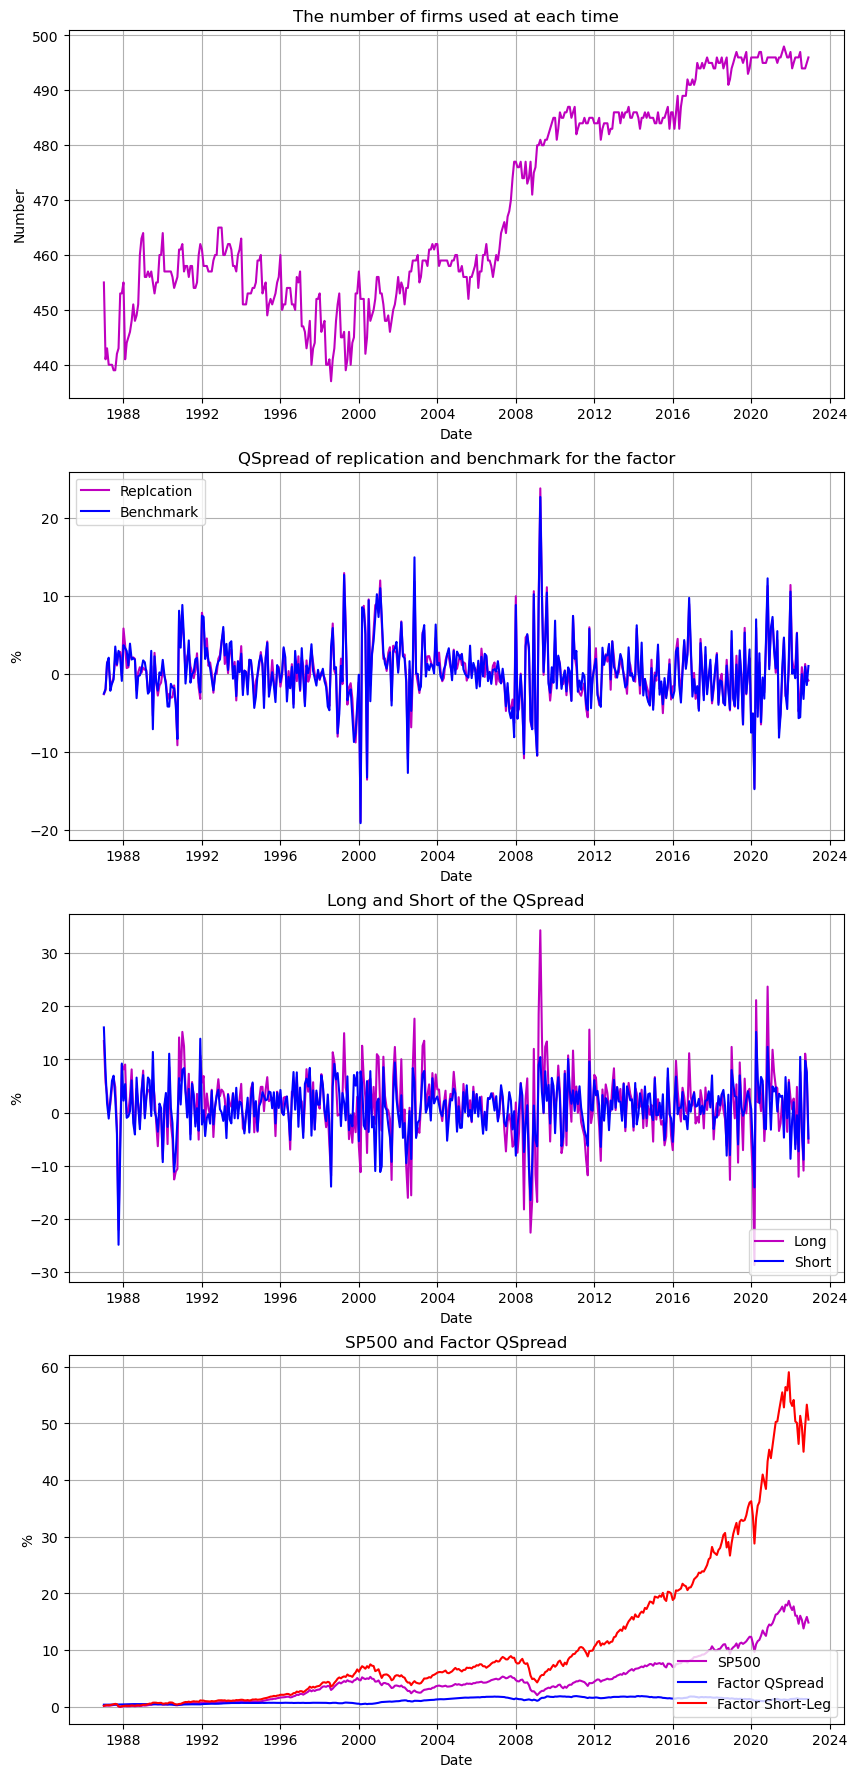

In [75]:
import datetime as dt
import matplotlib.dates as mdates

#compare whether we could replicate the factor returns from the existing benchmark
benchmark = Benchmark[['Date','BP']].copy(deep= True)
benchmark['Date'] = pd.to_datetime(benchmark['Date'].astype(str),format = '%Y%m%d')
benchmark['Date'] = benchmark['Date'].apply(lambda x: x.strftime('%Y%m'))

idx_t_start= Date_Unique.index(int(benchmark['Date'].iloc[0]))
idx_t_end= Date_Unique.index(int(benchmark['Date'].iloc[-1]))

test_factor = BM_Factor_Sort[idx_t_start:idx_t_end+1]
test_Qspread = BM_Qspread[idx_t_start:idx_t_end+1]
test_long = BM_RET_Sort_top[idx_t_start:idx_t_end+1]
test_short = BM_RET_Sort_bottom[idx_t_start:idx_t_end+1]

sp500 = SP500[idx_t_start:idx_t_end+1]

list_nfirms = []
list_long = []
list_short = []

for idx_t in range(len(test_factor)):
    list_nfirms.append(len(test_factor[idx_t]))
    
for idx_t in range(len(test_long)):
    list_long.append(np.nanmean(test_long[idx_t]['trt1m']))
    list_short.append(np.nanmean(test_short[idx_t]['trt1m']))
    
ret_sp500 = np.exp(np.cumsum(np.log(1+sp500['ret_sp500'])))-1     # calculate the cumulative return of sp500 from start to end date 
ret_Qspread = np.exp(np.cumsum(np.log(1+np.array(test_Qspread)/100))-1)  # calculate the cumlutatve return of Qspread 
ret_Long = np.exp(np.cumsum(np.log(1+np.array(list_long)/100)))-1  # calculate the cumlutatve return of long portfolio
ret_Short = np.exp(np.cumsum(np.log(1+np.array(list_short)/100)))-1 # calculate the cumlutatve return of short portfolio


plt.figure(figsize = (10,22))
plt.subplot(4,1,1)  # configures a subplot of first subplot among 4 rows and 1 column
xvalues = [dt.datetime.strptime(d, "%Y%m").date() for d
          in np.asarray(benchmark['Date']).astype(str)]
plt.plot(xvalues, list_nfirms, '-m', label = "The number of firms used at each time") # Plot the number of firms at each time point
#plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Number')
plt.grid(True)   # Add a grid to the current plot for better visualization
plt.title('The number of firms used at each time')   # Add corresponding title to the plot

plt.subplot(4,1,2)
plt.plot(xvalues, test_Qspread, '-m', label = "Replcation")
plt.plot(xvalues, benchmark['BP'].values, '-b', label = "Benchmark")
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('%')
plt.grid(True)
plt.title('QSpread of replication and benchmark for the factor')

plt.subplot(4,1,3)
plt.plot(xvalues,list_long, '-m', label ="Long")
plt.plot(xvalues, list_short, '-b', label = "Short")
plt.legend(loc= 'lower right')
plt.xlabel('Date')
plt.ylabel('%')
plt.grid(True)
plt.title('Long and Short of the QSpread')

plt.subplot(4,1,4)
plt.plot(xvalues, ret_sp500, '-m', label = "SP500")
plt.plot(xvalues, ret_Qspread, '-b',label = "Factor QSpread")
plt.plot(xvalues, ret_Short, '-r', label = "Factor Short-Leg")
plt.legend(loc = 'lower right')
plt.xlabel('Date')
plt.ylabel('%')
plt.grid(True)
plt.title('SP500 and Factor QSpread')

plt.show()

The factor BP has a flat Qspread as compare to the return of SP500, indicating that the top performers and the bottom performers using factor BP as a strategy is not as effective as direct investing into SP500. 
The performances are not comparable as illustrated in the plot, which may be due to the diversified portfolio with growth stocks in SP500, whereas BP strategy only focuses on company fundamentals and overlook stock's performance affected by macroeconomic factors and market forces. 
As shown in the plot below, long-leg contributes more to the factor performance. 
Both the long and short return performs poorly during recession. 

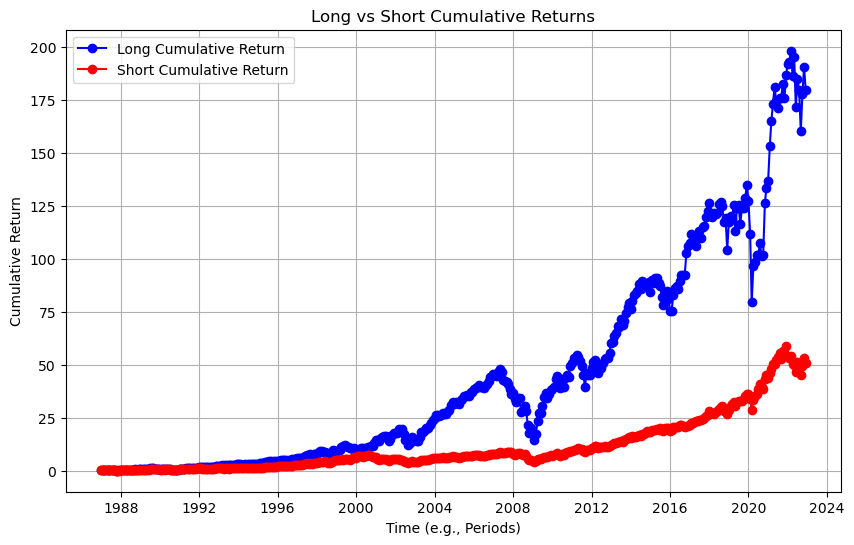

In [79]:
plt.figure(figsize=(10, 6))
plt.plot(xvalues, ret_Long, label='Long Cumulative Return', color='blue', marker='o')
plt.plot(xvalues, ret_Short, label='Short Cumulative Return', color='red', marker='o')
plt.xlabel('Time (e.g., Periods)')
plt.ylabel('Cumulative Return')
plt.title('Long vs Short Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

Q2:  
Compare the replication to the benchmark  
Compute the correlation coefficients for each repliacted factor with its benchmark;  
Pick the same period of the benchmarket;  
The factor to be tested: MV, BM, HL1M  
The criteria is a correlation coefficient greater than 0.9 (if the correlation is negative, take the inverse)  

In [82]:
from scipy import stats
list_factors = ['MV','BM','HL1M','S&P500']
test_MV_Qspread = MV_Qspread[idx_t_start: idx_t_end+1]
test_BM_Qspread = BM_Qspread[idx_t_start: idx_t_end+1]
test_HL1M_Qspread = HL1M_Qspread[idx_t_start: idx_t_end+1]

list_corr= []
list_corr.append(stats.pearsonr(test_MV_Qspread, Benchmark['LogMktCap'])[0])  # Computes correlation between MV quantile spread and logarithm of market cap
list_corr.append(stats.pearsonr(test_BM_Qspread, Benchmark['BP'])[0])
list_corr.append(stats.pearsonr(test_HL1M_Qspread, Benchmark['HL1M'])[0])


# Construct a dataframe to show the correalation beteween Qspread of the three factors and benchmark
df_corr = pd.DataFrame(list(zip(list_factors, list_corr)), columns = ['Factor', 'Corr'])
df_corr

,Factor,Corr
0,MV,0.992169
1,BM,0.973885
2,HL1M,0.128797


In [45]:
list_mean = []
list_std = []
list_sr = []
list_skew = []
list_kurt = []
list_max = []
list_min = []
list_acf1 = []
list_acf12 = []
list_acf24 = []

list_test_factors = [test_MV_Qspread, test_BM_Qspread, test_HL1M_Qspread, sp500['ret_sp500']]

# compute descriptive statistics for each factor's time series in list_test_factors
for idx in range(len(list_test_factors)):
    list_mean.append(np.nanmean(list_test_factors[idx]))
    list_std.append(np.nanstd(list_test_factors[idx]))
    list_sr.append(np.sqrt(12)*list_mean[idx]/list_std[idx])
    list_skew.append(stats.skew(list_test_factors[idx]))
    list_kurt.append(stats.kurtosis(list_test_factors[idx]))
    list_max.append(np.nanmax(list_test_factors[idx]))
    list_min.append(np.nanmin(list_test_factors[idx]))
    list_acf1.append(sm.tsa.acf(list_test_factors[idx], nlags=24, fft=False)[1])
    list_acf12.append(sm.tsa.acf(list_test_factors[idx], nlags=24, fft=False)[12])
    list_acf24.append(sm.tsa.acf(list_test_factors[idx], nlags=24, fft=False)[24])

df_table = pd.DataFrame(list(zip(list_mean, list_std, list_sr, list_skew, list_kurt,
                                 list_max, list_min, list_acf1, list_acf12, list_acf24)), 
                        columns = ['Mean', 'STD', 'Sharpe Ratio', 'Skewness', 'Kurtosis', 
                                   'Max', 'Min', 'ACF1', 'ACF12', 'ACF24'])

df_table.index = list_factors
df_table.T

,MV,BM,HL1M,S&P500
Mean,-0.351353,0.380835,-0.007675,0.007414
STD,3.989772,4.006618,1.271687,0.044229
Sharpe Ratio,-0.305060,0.329268,-0.020908,0.580661
Skewness,-1.080343,0.309535,-0.095749,-0.727039
Kurtosis,9.677470,4.671547,1.082461,2.097639
Max,19.610220,23.844838,5.178978,0.131767
Min,-30.725582,-18.943367,-4.553611,-0.217630
ACF1,0.172911,0.164694,0.024845,0.023915
ACF12,0.140895,0.014665,0.036650,0.034097
ACF24,0.064719,-0.022511,-0.061162,0.050344


In [49]:
df_test_factors = pd.DataFrame(list(zip(test_MV_Qspread, test_BM_Qspread, 
                                       test_HL1M_Qspread, sp500['ret_sp500'])), columns = list_factors)

# Compute the correlation matrix between the three factors and S&P500
pd.DataFrame(np.corrcoef(df_test_factors.T), columns = list_factors, 
             index = list_factors)

,MV,BM,HL1M,S&P500
MV,1.000000,-0.731410,-0.054037,-0.328232
BM,-0.731410,1.000000,0.031737,0.187299
HL1M,-0.054037,0.031737,1.000000,0.103429
S&P500,-0.328232,0.187299,0.103429,1.000000


**MV Factor**:  
**Advantage**: May capture market mispricing if the timing and selection are effective.  
**Disadvantage**: Consistently negative returns and riskier distribution characteristics make it unattractive on its own.  

**BM Factor**:  
**Advantage**: The positive mean return indicates potential upside through value investing strategies where undervalued stocks could correct upward.  
The slightly positive skew is a bonus, as it implies fewer downside surprises.  
**Disadvantage**: Risk-adjusted performance (Sharpe of 0.33) is lower than that of the S&P 500. Also, the high volatility means that performance can be choppy.  
  
**HL1M Factor**:  
**Advantage**: Low volatility might suit risk-averse strategies.
**Disadvantage**: The lack of meaningful return means it adds little value to a portfolio.  
  
**S&P 500 (Benchmark Index)**:  
**Advantages**: Diversification and stability, representing broad market exposure.  
Best risk-adjusted performance among the choices.  
**Disadvantages**:
As an index, it does not offer specific factor exposure that might capture unique mispricings (e.g., undervalued stocks).

BM factor is recommended as it has a positive mean value among the three and exhibits moderate risk with a Sharpe ratio of 0.33. Also, its return distribution (with slight positive skew) is more favorable than MV, reducing the risk of extreme downsides.

In [59]:
list_mean = []
list_tstats = []
list_pvalue = []

# Iterate Over Each Factor's Data
for idx in range(len(list_test_factors)):
    list_mean.append(np.nanmean(list_test_factors[idx]))
    list_tstats.append(stats.ttest_1samp(list_test_factors[idx], 0)[0]) # Perform a One-Sample t-Test and Append the t-Statistic
    list_pvalue.append(stats.ttest_1samp(list_test_factors[idx], 0)[1])

df_table_test = pd.DataFrame(list(zip(list_mean, list_tstats, list_pvalue)), 
                             columns = ['Mean', 'T Stats', 'p-Value'])
df_table_test.index = list_factors # Set the index to the factor names
df_table_test 

,Mean,T Stats,p-Value
MV,-0.351353,-1.828242,0.068204
BM,0.380835,1.973318,0.049098
HL1M,-0.007675,-0.125303,0.900342
S&P500,0.007414,3.479930,0.000553


**BM (Book-to-Market):**  
The positive and statistically significant return is in line with expectations for a value-based strategy, which often relies on the concept of undervaluation and subsequent mean reversion.  
  
**MV (Market Value):**  
The negative return (though borderline) may be consistent with the idea that exposure to market value alone (or a specific interpretation of MV) might capture underperforming segments—however, it deserves further investigation to understand its drivers.  
  
**HL1M:**  
Its near-zero return suggests it might not be intended as a core return-driver but rather as a factor measuring short-term price range or volatility.  
  
**S&P500:**  
As a benchmark index, its statistically significant performance reflects the broad market's consistent, albeit modest, return when measured against its low volatility profile.